In [2]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm

# Recreating the logisitc equation with inference using MCMC

In [3]:
print("Running version :{}".format(pm.__version__))

Running version :3.5


In [4]:
plt.style.use("seaborn-darkgrid")

np.random.seed(6)
random.seed(2018)


#True parameter values
true_lambda = random.random()
sigma = 0.07

t_values = np.linspace(-5,15,51)
print(len(t_values))

51


In [5]:
def diff_eqn_solution(true_lambda, t):
    return np.exp(true_lambda*t)/(1 + np.exp(true_lambda*t))

In [6]:
sim_df = pd.DataFrame(index=t_values)
sim_df["true_values"] = diff_eqn_solution(true_lambda, sim_df.index)
sim_df["sim_values"] = np.zeros(len(sim_df.index))

for index, row in sim_df.iterrows():
    sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, sigma)

In [7]:
Y = sim_df["sim_values"]

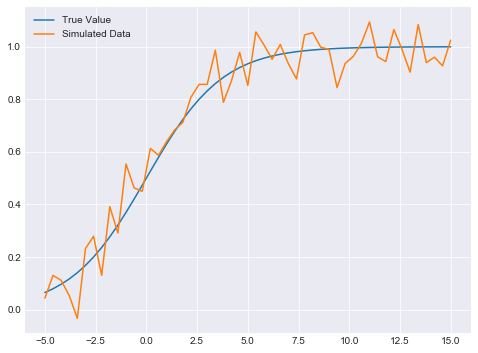

In [13]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sim_df["true_values"])
plt.plot(Y)
plt.legend(["True Value", "Simulated Data"])

In [14]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    t_lambda = pm.Uniform('t_lambda', lower=0.0, upper=1.0)

    # Expected value of outcome
    mu = diff_eqn_solution(t_lambda, sim_df.index)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Will be using the Maximum a Posteriori (MAP) method to find our $\lambda$. This gives the mode of the posterior distribution, since we have the modellined the draw of our data as i.i.d Normal, the mode is a good representitation for our data.

In [15]:
map_estimate = pm.find_MAP(model = basic_model)

logp = 60.513, ||grad|| = 9.784: 100%|██████████████████████████████████████████████████| 7/7 [00:00<00:00, 639.75it/s]


In [16]:
map_estimate

{'t_lambda_interval__': array(0.21266597564924744),
 't_lambda': array(0.5529670167603246)}

In [17]:
true_lambda

0.5331579307274593

# Experiment Repeatablity

Lets consider that we repeat this test several times and instead of $\lambda$ having one true fixed value, it takes a value within a small range, say,  $ \lambda \: \in \: [0.5, 0.55]$.

Each experiment will draw a lambda from this range uniformly and we will have simulate the data in the same way. From here we then can perform the same inference for each individual experiment and take an average of our distributions.

For experiment, $E_i$ where $i = 1,2,...,n$ :

$$ \lambda_i \sim \text{Uniform}(0.5, 0.55) $$

In [31]:
lambda_range = [0.5, 0.55]

lambda_map_estimates = []

#run the experiment 10 times
#here we have to create 10 new simualted dataframes with a lambda drawn from range and then perform the same inference
#the resulting dataframe distributions will be saved to a dictionary.
for num in range(10):

    true_lambda = np.random.uniform(lambda_range[0], lambda_range[1])
    sim_df = pd.DataFrame(index=t_values)
    sim_df["true_values"] = diff_eqn_solution(true_lambda, sim_df.index)
    sim_df["sim_values"] = np.zeros(len(sim_df.index))
    
    for index, row in sim_df.iterrows():
        sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, sigma)
    
    Y = sim_df["sim_values"]
    
    basic_model = pm.Model()

    with basic_model:
        t_lambda = pm.Uniform('t_lambda', lower=0.0, upper=1.0)
        mu = diff_eqn_solution(t_lambda, sim_df.index)
        Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
    map_estimate = pm.find_MAP(model = basic_model)
    lambda_map_estimates.append(map_estimate["t_lambda"])

logp = 65.891, ||grad|| = 15.259: 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 776.74it/s]
logp = 57.063, ||grad|| = 5.3706: 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 896.66it/s]
logp = 69.07, ||grad|| = 2.426: 100%|███████████████████████████████████████████████████| 7/7 [00:00<00:00, 868.54it/s]
logp = 65.06, ||grad|| = 11.229: 100%|█████████████████████████████████████████████████| 8/8 [00:00<00:00, 1534.13it/s]
logp = 68.091, ||grad|| = 9.8743: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 1158.83it/s]
logp = 65.484, ||grad|| = 2.1446: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 1271.88it/s]
logp = 61.656, ||grad|| = 3.4729: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 1239.87it/s]
logp = 66.277, ||grad|| = 7.8573: 100%|█████████████████████████████████████████████████| 8/8 [00:00<00:00, 892.26it/s]
logp = 59.026, ||grad|| = 9.8668: 100%|█

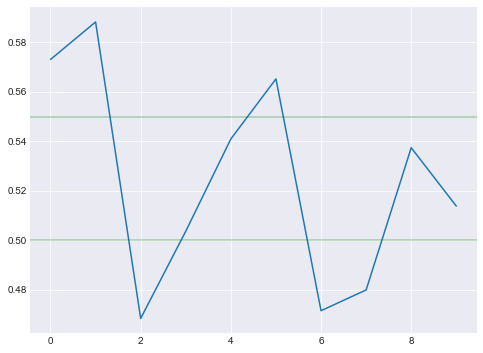

In [19]:
plt.plot(lambda_map_estimates)
plt.axhline(y=0.55, color="g", alpha = 0.3)
plt.axhline(y=0.50, color="g", alpha = 0.3)

In [21]:
help(pm.find_MAP)

Help on function find_MAP in module pymc3.tuning.starting:

find_MAP(start=None, vars=None, method='L-BFGS-B', return_raw=False, include_transformed=True, progressbar=True, maxeval=5000, model=None, *args, **kwargs)
    Finds the local maximum a posteriori point given a model.
    
    Parameters
    ----------
    start : `dict` of parameter values (Defaults to `model.test_point`)
    vars : list
        List of variables to optimize and set to optimum (Defaults to all continuous).
    method : string or callable
        Optimization algorithm (Defaults to 'L-BFGS-B' unless
        discrete variables are specified in `vars`, then
        `Powell` which will perform better).  For instructions on use of a callable,
        refer to SciPy's documentation of `optimize.minimize`.
    return_raw : bool
        Whether to return the full output of scipy.optimize.minimize (Defaults to `False`)
    include_transformed : bool
        Flag for reporting automatically transformed variables in add

In [28]:
error_list_055 = []
error_list_05 = []

for est in lambda_map_estimates:
    if est > 0.55:
        error_list_055.append(est -0.55)
    elif est < 0.5:
        error_list_05.append(0.5 - est)

In [30]:
(np.average(error_list_055) + np.average(error_list_05))/2.0 

0.026092623269564574